In [ ]:
import cv2
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from NegPearsonsCorrLoss import NegPearsonsCorrLoss

In [ ]:
sys.path.append("d:/Happy-rPPG-Toolkit")

In [44]:
"""
RhythmFormer:Extracting rPPG Signals Based on Hierarchical Temporal Periodic Transformer
"""
from typing import Optional
import torch
from torch import nn
import math
from typing import Tuple, Union
from fairscale.nn.checkpoint import checkpoint_wrapper
from timm.models.layers import trunc_normal_
from models.base.video_bra import video_BiFormerBlock
from models.base.TAdaConv import TAdaConv2d, RouteFuncMLP
from thop import profile


class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_c, in_c, kernel_size=[1, 5, 5], stride=[1, 2, 2], padding=[0, 2, 2], groups=in_c),  # Depthwise
            nn.Conv3d(in_c, out_c, kernel_size=1, stride=1, padding=0),  # Pointwise
            nn.AvgPool3d(kernel_size=[1, 2, 2], stride=[1, 2, 2]),
            nn.BatchNorm3d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
class TSDM_Module(nn.Module):
    def __init__(self, in_c=3, out_c=3, mode='WTS'):
        """
        mode: 'TSDM' or 'TSDMW'
        """
        super(TSDM_Module, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        self.mode = mode
        # self.stem1 = ConvBlock(in_c, out_c)
        self.stem2 = ConvBlock(in_c, out_c)

    def compute_diff(self, x):
        N, C, D, H, W = x.shape
        if self.mode == 'CTS':
            x1 = torch.cat([x[:, :C//2, :1, :, :], x[:, :C//2, :D-1, :, :]], dim=2)
            x3 = torch.cat([x[:, C//2:, 1:, :, :], x[:, C//2:, D-1:, :, :]], dim=2)
        elif self.mode == 'WTS':
            x1 = torch.cat([x[:, :C//2, D-1:, :, :], x[:, :C//2, :D-1, :, :]], dim=2)
            x3 = torch.cat([x[:, C//2:, 1:, :, :], x[:, C//2:, :1, :, :]], dim=2)
        elif self.mode == 'PTS':
            zero_pad1 = torch.zeros_like(x[:, :C // 2, :1, :, :])  # 生成全 0 张量
            zero_pad2 = torch.zeros_like(x[:, C // 2:, :1, :, :])  # 确保和 x3 形状匹配
            x1 = torch.cat([zero_pad1, x[:, :C//2, :D-1, :, :]], dim=2)  # 用 0 进行填充
            x3 = torch.cat([x[:, C//2:, 1:, :, :], zero_pad2], dim=2)
        return torch.cat([x[:, :C//2, :, :, :] - x1, x3 - x[:, C//2:, :, :, :]], dim=1)

    def forward(self, x):
        N, C, D, H, W = x.shape
        # x_diff = self.compute_diff(x)
        # x_diff = self.stem1(x_diff)
        x = self.stem2(x)
        # x = x_diff  #x2 +
        return x

class TPT_Block(nn.Module):
    def __init__(self, dim, depth, num_heads, t_patch, topk,
                 mlp_ratio=4., drop_path=0., side_dwconv=5):
        super().__init__()
        self.dim = dim
        self.depth = depth
        ############ downsample layers & upsample layers #####################
        self.downsample_layers = nn.ModuleList()
        self.upsample_layers = nn.ModuleList()
        self.layer_n = int(math.log(t_patch, 2))
        for i in range(self.layer_n):
            downsample_layer = nn.Sequential(
                nn.BatchNorm3d(dim),
                nn.Conv3d(dim, dim, kernel_size=(2, 1, 1), stride=(2, 1, 1)),
            )
            self.downsample_layers.append(downsample_layer)
            upsample_layer = nn.Sequential(
                nn.Upsample(scale_factor=(2, 1, 1)),
                nn.Conv3d(dim, dim, [3, 1, 1], stride=1, padding=(1, 0, 0)),
                nn.BatchNorm3d(dim),
                nn.ELU(),
            )
            self.upsample_layers.append(upsample_layer)
        ######################################################################
        self.blocks = nn.ModuleList([
            video_BiFormerBlock(
                dim=dim,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                num_heads=num_heads,
                t_patch=t_patch,
                topk=topk,
                mlp_ratio=mlp_ratio,
                side_dwconv=side_dwconv,
            )
            for i in range(depth)
        ])

    def forward(self, x: torch.Tensor):
        """Definition of TPT_Block.
        Args:
          x [N,D,C,H,W]
        Returns:
          x [N,D,C,H,W]
        """
        for i in range(self.layer_n):
            x = self.downsample_layers[i](x)
        for blk in self.blocks:
            x = blk(x)
        for i in range(self.layer_n):
            x = self.upsample_layers[i](x)

        return x


class TSDMFormer(nn.Module):

    def __init__(
            self,
            name: Optional[str] = None,
            pretrained: bool = False,
            dim: int = 64, frame: int = 160,
            image_size: Optional[int] = (160, 128, 128),
            in_chans=64, head_dim=16,
            stage_n=3,
            embed_dim=[64, 64, 64], mlp_ratios=[1.5, 1.5, 1.5],
            depth=[2, 2, 2],
            t_patchs: Union[int, Tuple[int]] = (2, 4, 8),
            topks: Union[int, Tuple[int]] = (40, 40, 40),
            side_dwconv: int = 3,
            drop_path_rate=0.,
            use_checkpoint_stages=[],
    ):
        super().__init__()

        self.image_size = image_size
        self.frame = frame
        self.dim = dim
        self.stage_n = stage_n

        # self.Fusion_Stem = Fusion_Stem()
        self.TSDM = TSDM_Module(3,  64, 'WTS')
        self.patch_embedding = nn.Conv3d(in_chans, embed_dim[0], kernel_size=(1, 4, 4), stride=(1, 4, 4))
        self.ConvBlockLast = nn.Conv1d(embed_dim[-1], 1, kernel_size=1, stride=1, padding=0)

        ##########################################################################
        self.stages = nn.ModuleList()
        nheads = [dim // head_dim for dim in embed_dim]  # [4, 4, 4]
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depth))]  # [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        for i in range(stage_n):
            stage = TPT_Block(dim=embed_dim[i],
                              depth=depth[i],
                              num_heads=nheads[i],
                              mlp_ratio=mlp_ratios[i],
                              drop_path=dp_rates[sum(depth[:i]):sum(depth[:i + 1])],
                              t_patch=t_patchs[i], topk=topks[i], side_dwconv=side_dwconv
                              )
            if i in use_checkpoint_stages:
                stage = checkpoint_wrapper(stage)
            self.stages.append(stage)
        ##########################################################################

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        N, C, D, H, W = x.shape  # [N D 3 128 128]
        # x = self.Fusion_Stem(x)  # [N*D 64 H/4 W/4]
        # x = x.transpose(1, 2)
        x = self.TSDM(x)
        # x = x.view(N, D, 64, H // 4, W // 4).permute(0, 2, 1, 3, 4)  # [N 64 D 32 32]
        x = self.patch_embedding(x)  # [N 64 D 8 8]
        for i in range(3):
            x = self.stages[i](x)  # [N 64 D 8 8]

        features_last = torch.mean(x, 3)  # [N, 64, D, 8]
        features_last = torch.mean(features_last, 3)  # [N, 64, D]
        rPPG = self.ConvBlockLast(features_last)  # [N, 1, D]
        rPPG = rPPG.squeeze(1)
        return rPPG


if __name__ == '__main__':

    input = torch.randn((1, 3, 1560, 128, 128))  # , dtype=torch.float32
    model = TSDMFormer()

    out = model(input)
    print(out.shape)


torch.Size([1, 1560])


In [30]:
device = torch.device('cpu')
model = TSDMFormer().to(device).eval()
model.load_state_dict(torch.load('../weights/TSDMFormer_UBFCrPPG_sceneRaw_fold1_42_TH_best.pth', map_location=device))

<All keys matched successfully>

In [33]:
import os
data_root = 'E:/UBFCrPPG'
test_files_paths = sorted([os.path.join(data_root, f) for f in os.listdir(data_root)])

In [ ]:
test_files_paths

In [73]:
test_len = 600
with h5py.File(test_files_paths[0], 'r') as f:
    imgs = f['imgs'][:test_len]
    bvp = f['bvp'][:test_len]

In [74]:
img_batch = imgs
img_batch = img_batch.transpose((3,0,1,2))
img_batch = img_batch[np.newaxis].astype('float32')
img_batch = torch.tensor(img_batch, requires_grad=True).to(device)

In [75]:
img_batch.shape

torch.Size([1, 3, 600, 128, 128])

In [76]:
rppg = model(img_batch)

In [77]:
NPC = NegPearsonsCorrLoss()
bvp = bvp[np.newaxis].astype('float32')
bvp = torch.tensor(bvp).to(device)

In [78]:
grad_input, = torch.autograd.grad(NPC(bvp, rppg), img_batch)
grad_input = grad_input.detach().cpu().numpy()

(-0.5, 127.5, 127.5, -0.5)

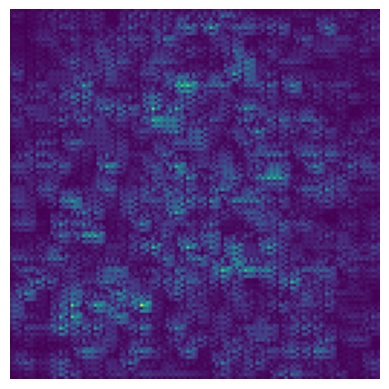

In [100]:
%matplotlib inline
plt.figure()
i = 10
plt.imshow(np.abs(grad_input[0,1,i]))
plt.axis('off')
# plt.savefig("sa%d.png"%i,bbox_inches='tight')
# plt.colorbar()

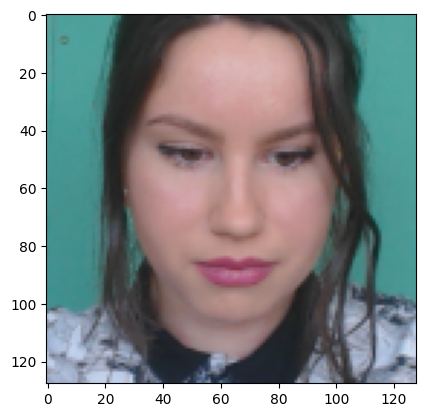

In [97]:
plt.figure()

plt.imshow(imgs[i])
# cv2.imwrite("img%d.png"%i, cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))